# XGB Model Training and SHAP computation using the Synthetic-events Dataset

**Author: Tesfagabir Meharizghi<br>Last Updated: 01/11/2021**

This notebook does the following actions:
- Models training using the given hyperparameter ranges
- Model selection using Intersection Similarity Score between ground truth helping features and predicted ones
    * Early stopping using Intersection similarity score criteria
- Computes SHAP values and visualizes for a few positive examples and positive predictions
- Visualizes the train/val/test probability scores from each trained model if needed
- Visualizes the Intersection Similarity Scores for val/test splits
- Finally, after tweaking the parameters, it gets the best model for the given model architecture and dataset

Outputs:
- The following artifacts are saved:
    * Model artifacts
    * SHAP values and their corresponding scores for the specified number of val/test examples

Model Architecture Used:
- XGB

Dataset:
- Synthetic-events (Toy Dataset)

Requirements:
- Make sure that you have already generated the synthetic toy dataset (train/val/test splits) using [Create_toy_dataset.ipynb](../../data/toy_dataset/Create_toy_dataset.ipynb).

Next Steps:
- Once you train different models, save the best one you found
- Do also the same for other models architectures (SimpleLSTM, LSTM+Attention, etc.) using the separate notebooks
- Finally, go to [02_4_synthetic_shap_jacc.ipynb](02_4_synthetic_shap_jacc.ipynb) to compare to compare the models' performances and shap values usig Jaccard Similarity Index

In [1]:
# pip install nb-black

In [2]:
#! pip install botocore==1.12.201

#! pip install shap
#! pip install xgboost

In [3]:
%load_ext lab_black

%load_ext autoreload

%autoreload 2

In [4]:
import os
import time
import torch
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from urllib.parse import urlparse
import tarfile
import pickle
import shutil
from collections import Counter, defaultdict, OrderedDict

import shap
import xgboost as xgb

import sagemaker
import boto3
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.image_uris import retrieve

import deep_id_pytorch

import xgboost_utils as xgb_utils
import shap_jacc_utils as sj_utils

## XGB Model Training

### Constants

In [5]:
# For seq_len=30
seq_len = 30
TUNING_JOB_NAME = (
    "sagemaker-xgboost-210112-0531"  # Set None if you want to train a new HPO job
)

# For seq_len=300
# seq_len = 300
# TUNING_JOB_NAME = None
# TUNING_JOB_NAME = "sagemaker-xgboost-210112-0615"  # Set None if you want to train a new HPO job

# For seq_len=900
# seq_len = 900
# TUNING_JOB_NAME = None
# TUNING_JOB_NAME = (
#     "sagemaker-xgboost-210112-0635"  # Set None if you want to train a new HPO job
# )

SAVE_SHAP_OUTPUT = True

nrows = 1e9

target_colname = "label"
uid_colname = "patient_id"
target_value = "1"

rev = False

model_name = "xgb"
dataset = "Synthetic-events"

# For model early stopping criteria
EARLY_STOPPING = "intersection_similarity"  # Values are any of these: ['intersection_similarity', 'loss']

# SHAP related constants
N_BACKGROUND = 500  # Number of background examples
BACKGROUND_NEGATIVE_ONLY = True  # If negative examples are used as background
TEST_POSITIVE_ONLY = True  # If only positive examples are selected
IS_TEST_RANDOM = (
    True  # If random test/val examples are selected for shap value computation
)
SORT_SHAP_VALUES = False  # Whether to sort per-patient shap values for visualization

SHAP_SCORE_ABSOLUTE = False  # Whether to consider the absolute value of a shap score #TODO: Check this before running.

train_data_path = f"../../data/toy_dataset/data/{seq_len}/train.csv"
valid_data_path = f"../../data/toy_dataset/data/{seq_len}/val.csv"
test_data_path = f"../../data/toy_dataset/data/{seq_len}/test.csv"

model_save_path = "./output/{}/{}/models/model_{}.pkl".format(seq_len, model_name, "{}")
shap_save_path_pattern = "./output/{}/{}/shap/{}_shap_{}.pkl".format(
    seq_len, model_name, "{}", "{}"
)  # SHAP values path for a given dataset split (train/val/test) (data format (features, scores, patient_ids))

# Dataset preprocessing
x_train_one_hot_path = f"output/{seq_len}/{model_name}/data/train_one_hot.csv"
x_valid_one_hot_path = f"output/{seq_len}/{model_name}/data/val_one_hot.csv"
x_test_one_hot_path = f"output/{seq_len}/{model_name}/data/test_one_hot.csv"

x_train_data_path = f"output/{seq_len}/{model_name}/data/train.csv"
x_valid_data_path = f"output/{seq_len}/{model_name}/data/val.csv"
x_test_data_path = f"output/{seq_len}/{model_name}/data/test.csv"

s3_output_data_dir = f"s3://merck-paper-bucket/{dataset}/{seq_len}/data"

# Model training
BUCKET = "merck-paper-bucket"
DATA_PREFIX = f"{dataset}/{seq_len}/data"
MODEL_PREFIX = f"{dataset}/{seq_len}/{model_name}".format(seq_len)
label = "label"

output_results_path = f"output/{seq_len}/{model_name}/hpo_results/results.csv"
local_model_dir = f"output/{seq_len}/{model_name}/models/"
s3_output_path = f"s3://{BUCKET}/{MODEL_PREFIX}/output"

###Algorithm config
ALGORITHM = "xgboost"
REPO_VERSION = "1.2-1"

###Hyperparameter tuning config
TRAIN_INSTANCE_TYPE = "ml.m5.4xlarge"  #'ml.m4.16xlarge'
TRAIN_INSTANCE_COUNT = 1
MAX_PARALLEL_JOBS = 4
MAX_TRAIN_JOBS = 10

EVALUATION_METRIC = "auc"
OBJECTIVE = "binary:logistic"
OBJECTIVE_METRIC_NAME = "validation:auc"

# Update hyperparameter ranges
# HYPERPARAMETER_RANGES = {'eta': ContinuousParameter(0, 1),
#                         'alpha': ContinuousParameter(0, 2),
#                         'max_depth': IntegerParameter(1, 10)}

HYPERPARAMETER_RANGES = {
    "eta": ContinuousParameter(0.1, 0.5),
    "alpha": ContinuousParameter(0, 2),
    "max_depth": IntegerParameter(1, 10),
    "gamma": ContinuousParameter(0, 5),
    "num_round": IntegerParameter(200, 500),
    "colsample_bylevel": ContinuousParameter(0.1, 1.0),
    "colsample_bynode": ContinuousParameter(0.1, 1.0),
    "colsample_bytree": ContinuousParameter(0.5, 1.0),
    "lambda": ContinuousParameter(0, 1000),
    "max_delta_step": IntegerParameter(0, 10),
    "min_child_weight": ContinuousParameter(0, 120),
    "subsample": ContinuousParameter(0.5, 1.0),
}

In [6]:
# Model Output Directory
model_save_dir = os.path.dirname(model_save_path)
shap_save_dir = os.path.dirname(shap_save_path_pattern)

if os.path.exists(model_save_dir):
    # Remove model save directory if exists
    shutil.rmtree(model_save_dir)
if os.path.exists(shap_save_dir):
    # Remove model save directory if exists
    shutil.rmtree(shap_save_dir)
os.makedirs(model_save_dir)
os.makedirs(shap_save_dir)
print(f"New directory created: {model_save_dir}")
print(f"New directory created: {shap_save_dir}")

New directory created: ./output/30/xgb/models
New directory created: ./output/30/xgb/shap


## 2. XGBoost Model Training

### Data Preprocessing

In [7]:
df = pd.read_csv(train_data_path)
print(df.shape)
df.head()

(18000, 33)


,index,29,28,27,26,25,24,23,22,21,...,7,6,5,4,3,2,1,0,label,patient_id
0,2741,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,apnea_H,headache_N,cold_sore_N,high_creatinine_H,high_creatinine_H,myopia_N,cold_sore_N,cut_finger_N,1,YYZP9V6PWV
1,1615,<pad>,<pad>,<pad>,myopia_N,myopia_N,headache_N,myopia_N,apnea_H,normal_bmi_U,...,foot_pain_N,headache_N,backache_N,foot_pain_N,hay_fever_N,furosemide_H,ACL_tear_N,ACL_tear_N,1,4VX2RBGZE0
2,852,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,eye_exam_N,ankle_sprain_N,myopia_N,...,cold_sore_N,hay_fever_N,headache_N,foot_pain_N,cold_sore_N,cold_sore_N,hay_fever_N,backache_N,0,6U018NSHLS
3,2749,<pad>,<pad>,eye_exam_N,ingrown_nail_N,headache_N,myopia_N,headache_N,ingrown_nail_N,cut_finger_N,...,myopia_N,tachycardia_H,cold_sore_N,myopia_N,backache_N,cut_finger_N,hay_fever_N,headache_N,1,CLEDNASY68
4,2090,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,cold_sore_N,foot_pain_N,eye_exam_N,backache_N,myopia_N,cut_finger_N,ACL_tear_N,hay_fever_N,1,XV86JBVK2M


In [8]:
tokens = xgb_utils.get_valid_tokens(df, seq_len)

In [9]:
if TUNING_JOB_NAME is None:
    xgb_utils.prepare_data(
        train_data_path,
        x_train_one_hot_path,
        x_train_data_path,
        seq_len,
        target_colname,
        tokens,
        s3_output_data_dir,
    )
    xgb_utils.prepare_data(
        valid_data_path,
        x_valid_one_hot_path,
        x_valid_data_path,
        seq_len,
        target_colname,
        tokens,
        s3_output_data_dir,
    )
    xgb_utils.prepare_data(
        test_data_path,
        x_test_one_hot_path,
        x_test_data_path,
        seq_len,
        target_colname,
        tokens,
        s3_output_data_dir,
    )

### XGBoost Model Training

In [10]:
### SageMaker Initialization
region = boto3.Session().region_name
role = sagemaker.get_execution_role()
smclient = boto3.Session().client("sagemaker")

sess = sagemaker.Session()

container = retrieve(ALGORITHM, region, version=REPO_VERSION)

if TUNING_JOB_NAME is None:
    start = time.time()
    print("Training for seq_len={}, label={}...".format(seq_len, label))
    # Prepare the input train & validation data path
    s3_input_train = sagemaker.inputs.TrainingInput(
        s3_data="s3://{}/{}/train".format(BUCKET, DATA_PREFIX), content_type="csv"
    )
    s3_input_validation = sagemaker.inputs.TrainingInput(
        s3_data="s3://{}/{}/val".format(BUCKET, DATA_PREFIX), content_type="csv"
    )

    # Class Imbalance
    scale_pos_weight = 1.0  # negative/positive

    data_channels = {"train": s3_input_train, "validation": s3_input_validation}

    tuner = xgb_utils.train_hpo(
        hyperparameter_ranges=HYPERPARAMETER_RANGES,
        container=container,
        execution_role=role,
        instance_count=TRAIN_INSTANCE_COUNT,
        instance_type=TRAIN_INSTANCE_TYPE,
        output_path=s3_output_path,
        sagemaker_session=sess,
        eval_metric=EVALUATION_METRIC,
        objective=OBJECTIVE,
        objective_metric_name=OBJECTIVE_METRIC_NAME,
        max_train_jobs=MAX_TRAIN_JOBS,
        max_parallel_jobs=MAX_PARALLEL_JOBS,
        scale_pos_weight=scale_pos_weight,
        data_channels=data_channels,
    )

    # Get tuning job name
    smclient = boto3.Session().client("sagemaker")
    tuning_job_result = smclient.describe_hyper_parameter_tuning_job(
        HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
    )
    TUNING_JOB_NAME = tuning_job_result["HyperParameterTuningJobName"]

In [11]:
tuner = sagemaker.HyperparameterTuningJobAnalytics(TUNING_JOB_NAME)
is_minimize = False

full_df = tuner.dataframe()

if len(full_df) > 0:
    df_hpo = full_df[full_df["FinalObjectiveValue"] > -float("inf")]
    if len(df_hpo) > 0:
        df_hpo = df_hpo.sort_values("FinalObjectiveValue", ascending=is_minimize)
        pd.set_option("display.max_colwidth", -1)  # Don't truncate TrainingJobName
    else:
        print("No training jobs have reported valid results yet.")

    # Add other info
    df_hpo["model"] = model_name
    df_hpo["dataset"] = dataset
    df_hpo["seq_len"] = seq_len
else:
    print("No Training Job Found!")

print(df_hpo.shape)
df_hpo.head()

(10, 21)


,alpha,colsample_bylevel,colsample_bynode,colsample_bytree,eta,gamma,lambda,max_delta_step,max_depth,min_child_weight,...,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,model,dataset,seq_len
6,1.121858,0.940217,0.464990,0.903420,0.282452,0.432246,97.748164,8.0,3.0,33.831277,...,0.882715,sagemaker-xgboost-210112-0531-004-d49e5169,Completed,0.91139,2021-01-12 05:34:49+00:00,2021-01-12 05:40:48+00:00,359.0,xgb,Synthetic-events,30
3,0.486306,0.611950,0.471807,0.914386,0.393202,0.742503,7.006499,9.0,6.0,19.053194,...,0.890246,sagemaker-xgboost-210112-0531-007-9c8b998a,Completed,0.91110,2021-01-12 05:43:01+00:00,2021-01-12 05:44:10+00:00,69.0,xgb,Synthetic-events,30
4,1.165871,0.949742,0.523152,0.520684,0.235162,0.922764,239.367338,10.0,9.0,16.394502,...,0.850970,sagemaker-xgboost-210112-0531-006-32c10c19,Completed,0.91067,2021-01-12 05:43:11+00:00,2021-01-12 05:44:28+00:00,77.0,xgb,Synthetic-events,30
9,1.144895,0.394045,0.576115,0.840147,0.379013,2.584190,131.691557,9.0,10.0,81.698409,...,0.903343,sagemaker-xgboost-210112-0531-001-1b87985b,Completed,0.91038,2021-01-12 05:34:56+00:00,2021-01-12 05:40:20+00:00,324.0,xgb,Synthetic-events,30
5,0.796648,0.242057,0.832143,0.573337,0.226356,3.932713,854.765288,7.0,1.0,20.095577,...,0.685483,sagemaker-xgboost-210112-0531-005-383ccd2c,Completed,0.91017,2021-01-12 05:42:20+00:00,2021-01-12 05:43:22+00:00,62.0,xgb,Synthetic-events,30


In [12]:
def get_and_copy_training_job(row, s3_output_dir, local_output_dir):
    """Get a training job from s3 and copy to local dir."""
    job_name = row["TrainingJobName"]
    s3_model_path = os.path.join(s3_output_dir, job_name, "output/model.tar.gz")

    if not os.path.exists(local_output_dir):
        os.makedirs(local_output_dir)

    output_fname = f"{job_name}.tar.gz"
    local_model_path = os.path.join(local_output_dir, output_fname)

    command = f"aws s3 cp --quiet {s3_model_path} {local_model_path}"
    os.system(command)
    return s3_model_path, local_model_path


def save_hpo_results(df, output_path):
    """Save HPO training jobs metadata."""
    output_dir = os.path.dirname(output_path)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    df.to_csv(output_path, index=False)

In [13]:
print("Copying model artifacts from s3 to local...")
model_paths = df_hpo.apply(
    get_and_copy_training_job, args=(s3_output_path, local_model_dir), axis=1
)
print(f"Saving hpo train results to {output_results_path}...")
s3_paths = [path[0] for path in model_paths]
local_paths = [path[1] for path in model_paths]
df_hpo["s3_path"] = s3_paths
df_hpo["local_path"] = local_paths

save_hpo_results(df_hpo, output_results_path)
print("SUCCESS!")

Copying model artifacts from s3 to local...
Saving hpo train results to output/30/xgb/hpo_results/results.csv...
SUCCESS!


## Model Validation and Visualization

In [14]:
df_hpo = pd.read_csv(output_results_path)
print(df_hpo.shape)
df_hpo.head()

(10, 23)


,alpha,colsample_bylevel,colsample_bynode,colsample_bytree,eta,gamma,lambda,max_delta_step,max_depth,min_child_weight,...,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,model,dataset,seq_len,s3_path,local_path
0,1.121858,0.940217,0.464990,0.903420,0.282452,0.432246,97.748164,8.0,3.0,33.831277,...,Completed,0.91139,2021-01-12 05:34:49+00:00,2021-01-12 05:40:48+00:00,359.0,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/30/xgb/output/sagemaker-xgboost-210112-0531-004-d49e5169/output/model.tar.gz,output/30/xgb/models/sagemaker-xgboost-210112-0531-004-d49e5169.tar.gz
1,0.486306,0.611950,0.471807,0.914386,0.393202,0.742503,7.006499,9.0,6.0,19.053194,...,Completed,0.91110,2021-01-12 05:43:01+00:00,2021-01-12 05:44:10+00:00,69.0,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/30/xgb/output/sagemaker-xgboost-210112-0531-007-9c8b998a/output/model.tar.gz,output/30/xgb/models/sagemaker-xgboost-210112-0531-007-9c8b998a.tar.gz
2,1.165871,0.949742,0.523152,0.520684,0.235162,0.922764,239.367338,10.0,9.0,16.394502,...,Completed,0.91067,2021-01-12 05:43:11+00:00,2021-01-12 05:44:28+00:00,77.0,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/30/xgb/output/sagemaker-xgboost-210112-0531-006-32c10c19/output/model.tar.gz,output/30/xgb/models/sagemaker-xgboost-210112-0531-006-32c10c19.tar.gz
3,1.144895,0.394045,0.576115,0.840147,0.379013,2.584190,131.691557,9.0,10.0,81.698409,...,Completed,0.91038,2021-01-12 05:34:56+00:00,2021-01-12 05:40:20+00:00,324.0,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/30/xgb/output/sagemaker-xgboost-210112-0531-001-1b87985b/output/model.tar.gz,output/30/xgb/models/sagemaker-xgboost-210112-0531-001-1b87985b.tar.gz
4,0.796648,0.242057,0.832143,0.573337,0.226356,3.932713,854.765288,7.0,1.0,20.095577,...,Completed,0.91017,2021-01-12 05:42:20+00:00,2021-01-12 05:43:22+00:00,62.0,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/30/xgb/output/sagemaker-xgboost-210112-0531-005-383ccd2c/output/model.tar.gz,output/30/xgb/models/sagemaker-xgboost-210112-0531-005-383ccd2c.tar.gz


In [15]:
df_train = pd.read_csv(x_train_one_hot_path)
df_val = pd.read_csv(x_valid_one_hot_path)
df_test = pd.read_csv(x_test_one_hot_path)
print(df_train.shape, df_val.shape, df_test.shape)
df_val.head()

(18000, 32) (6000, 32) (6000, 32)


,patient_id,pneumonia_H,PH_A,tachycardia_H,hay_fever_N,CHF_A,foot_pain_N,backache_N,low_salt_diet_U,cold_sore_N,...,headache_N,PCI_U,dental_exam_N,AMI_A,furosemide_H,ACE_inhibitors_U,high_creatinine_H,eye_exam_N,ankle_sprain_N,label
0,LC90SE36SE,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
1,MB8F4SJBEF,0,0,0,0,0,1,1,1,0,...,1,0,1,0,1,0,0,0,0,0
2,PQNFP9E6H3,0,0,0,0,0,1,1,0,0,...,0,0,0,0,1,0,1,1,0,0
3,X5DYDLBGMS,1,0,1,1,0,1,1,0,1,...,1,1,0,0,0,0,0,1,1,0
4,UQS6JGLB5Z,0,0,0,1,0,0,1,1,1,...,1,0,1,0,0,0,1,1,1,0


In [22]:
# For each model.
def compute_shap(
    row,
    shap_path_pattern,
    df_train,
    df_val,
    df_test,
    absolute=True,
    test_positive_only=True,
    save_output=False,
    visualize=False,
):
    model_path = row["local_path"]
    job_name = row["TrainingJobName"]
    print(f"Processing for training job name = {job_name}...")
    val_shap_path = shap_save_path_pattern.format("val", job_name)
    test_shap_path = shap_save_path_pattern.format("test", job_name)
    # Load the copied model
    xgb_model = xgb_utils.load_model(model_path, remove=False)

    # Compute the val & test auc of the model
    X_train = df_train.iloc[:, 1:-1]
    X_val = df_val.iloc[:, 1:-1]
    X_test = df_test.iloc[:, 1:-1]

    train_auc = xgb_model.eval(
        xgb.DMatrix(X_train.values, df_train[target_colname].values)
    )
    train_prob_scores = xgb_model.predict(
        xgb.DMatrix(X_train.values, df_train[target_colname].values)
    )

    val_auc = xgb_model.eval(xgb.DMatrix(X_val.values, df_val[target_colname].values))
    val_prob_scores = xgb_model.predict(
        xgb.DMatrix(X_val.values, df_val[target_colname].values)
    )

    test_auc = xgb_model.eval(
        xgb.DMatrix(X_test.values, df_test[target_colname].values)
    )
    test_prob_scores = xgb_model.predict(
        xgb.DMatrix(X_test.values, df_test[target_colname].values)
    )

    train_auc = float(train_auc.rsplit(":", 1)[-1])
    val_auc = float(val_auc.rsplit(":", 1)[-1])
    test_auc = float(test_auc.rsplit(":", 1)[-1])
    print(f"Train AUC= {train_auc:.4f}, Val AUC={val_auc:.4f}, Test AUC={test_auc:.4f}")

    print("Computing SHAP values...")
    if save_output:
        (
            val_features,
            val_scores,
            val_patients,
        ) = sj_utils.get_xgboost_features_and_shap_scores(
            xgb_model,
            df_train,
            df_val,
            val_shap_path,
            save_output=save_output,
            n_test=None,
            n_background=None,
            background_negative_only=BACKGROUND_NEGATIVE_ONLY,
            test_positive_only=TEST_POSITIVE_ONLY,
            is_test_random=IS_TEST_RANDOM,
        )

        (
            test_features,
            test_scores,
            test_patients,
        ) = sj_utils.get_xgboost_features_and_shap_scores(
            xgb_model,
            df_train,
            df_test,
            test_shap_path,
            save_output=save_output,
            n_test=None,
            n_background=None,
            background_negative_only=BACKGROUND_NEGATIVE_ONLY,
            test_positive_only=TEST_POSITIVE_ONLY,
            is_test_random=IS_TEST_RANDOM,
        )
    else:
        (val_features, val_scores, val_patients) = sj_utils.load_pickle(val_shap_path)
        (test_features, test_scores, test_patients) = sj_utils.load_pickle(
            test_shap_path
        )

    # Get positive rows and data
    val_positive_rows = df_val.iloc[:, -1] == 1  # Only positive labels
    test_positive_rows = df_test.iloc[:, -1] == 1  # Only positive labels
    X_val = X_val[val_positive_rows]
    X_test = X_test[test_positive_rows]
    val_prob_scores = val_prob_scores[val_positive_rows].flatten().tolist()
    test_prob_scores = test_prob_scores[test_positive_rows].flatten().tolist()

    print("Computing Intersection Similarity...")
    val_avg_sim, val_sim = sj_utils.get_model_intersection_similarity(
        (val_features, val_scores), absolute=absolute, df_one_hot=X_val
    )
    test_avg_sim, test_sim = sj_utils.get_model_intersection_similarity(
        (test_features, test_scores), absolute=absolute, df_one_hot=X_test
    )
    print(f"Val Int. Simi={val_avg_sim:.4f}, Test Int. Simi={test_avg_sim:.4f}")
    print("*" * 100)

    if visualize:
        print("Ploting Histograms of Train/Val/Test Predicted Scores...")
        _, axes = plt.subplots(1, 3, sharex=False, figsize=(15, 5))
        # Train
        scores = train_prob_scores.flatten().tolist()
        axes = sj_utils.plot_histogram(
            scores,
            title=f"Train Scores (AUC={train_auc:.4f})",
            xlabel="Prediction Scores",
            ylabel="Frequencies",
            axes=axes,
            axes_idx=0,
        )
        # Val
        scores = val_prob_scores[:]
        axes = sj_utils.plot_histogram(
            scores,
            title=f"Val Scores (AUC={val_auc:.4f})",
            xlabel="Prediction Scores",
            ylabel="",
            axes=axes,
            axes_idx=1,
        )
        # Test
        scores = test_prob_scores[:]
        axes = sj_utils.plot_histogram(
            scores,
            title=f"Test Scores (AUC={test_auc:.4f})",
            xlabel="Prediction Scores",
            ylabel="",
            axes=axes,
            axes_idx=2,
        )
        plt.show()

        print("Visualizing SHAP values of VAL examples...")
        n_val = len(val_prob_scores)
        n_vis_examples = 0
        for idx in range(n_val):
            prob_scores1 = val_prob_scores[idx]  # Model prediction
            if n_vis_examples > 2:
                break
            features1 = val_features[idx]
            scores1 = val_scores[idx]
            patient_id = val_patients[idx]
            patient_id = f"{patient_id}, Probability={prob_scores1:.4f}"

            if prob_scores1 >= 0.8:
                df_shap = pd.DataFrame(
                    np.array([features1, scores1]).T, columns=["events", "shap_vals"]
                )
                df_shap["shap_vals"] = pd.to_numeric(df_shap["shap_vals"])

                sj_utils.plot_shap_values(
                    df_shap, patient_id, sort=SORT_SHAP_VALUES, figsize=(10, 5)
                )
                n_vis_examples += 1

        sj_utils.plot_histogram(
            val_sim,
            title=f"Average VAL Intersection Simi={val_avg_sim:.4f}",
            xlabel="Intersection Similarity",
            ylabel="Frequencies",
            axes=None,
        )

        print("Visualizing SHAP values of TEST examples...")
        num_test = len(test_prob_scores)
        n_vis_examples = 0
        for idx in range(num_test):
            prob_scores1 = test_prob_scores[idx]
            if n_vis_examples > 2:
                break
            features1 = test_features[idx]
            scores1 = test_scores[idx]
            patient_id = test_patients[idx]
            patient_id = f"{patient_id}, Probability={prob_scores1:.4f}"

            if prob_scores1 >= 0.8:
                df_shap = pd.DataFrame(
                    np.array([features1, scores1]).T, columns=["events", "shap_vals"]
                )
                df_shap["shap_vals"] = pd.to_numeric(df_shap["shap_vals"])

                sj_utils.plot_shap_values(
                    df_shap, patient_id, sort=SORT_SHAP_VALUES, figsize=(10, 5)
                )
                n_vis_examples += 1

        sj_utils.plot_histogram(
            test_sim,
            title=f"Average TEST Intersection Simi={test_avg_sim:.4f}",
            xlabel="Intersection Similarity",
            ylabel="Frequencies",
            axes=None,
        )
        print(
            "Finally computing and visualizing the global feature importance of the best model...."
        )
        feat_importance = sj_utils.get_global_feature_importance(
            test_features, test_scores, absolute=absolute
        )
        sj_utils.plot_global_feature_importance(feat_importance)
        print("All tasks SUCCESSFULLY completed!")

    result = (val_auc, test_auc, val_avg_sim, test_avg_sim)
    return result

In [17]:
visualize = False
results = df_hpo.apply(
    compute_shap,
    args=(
        shap_save_path_pattern,
        df_train,
        df_val,
        df_test,
        SHAP_SCORE_ABSOLUTE,
        TEST_POSITIVE_ONLY,
        SAVE_SHAP_OUTPUT,
        False,
    ),
    axis=1,
)

Processing for training job name = sagemaker-xgboost-210112-0531-004-d49e5169...
Train AUC= 0.9216, Val AUC=0.9114, Test AUC=0.8955
Computing SHAP values...


 99%|===================| 2976/2994 [00:15<00:00]        

saved ./output/30/xgb/shap/val_shap_sagemaker-xgboost-210112-0531-004-d49e5169.pkl pickle..


 99%|===================| 2985/3027 [00:15<00:00]        

saved ./output/30/xgb/shap/test_shap_sagemaker-xgboost-210112-0531-004-d49e5169.pkl pickle..
Computing Intersection Similarity...
Val Int. Simi=0.1446, Test Int. Simi=0.1448
****************************************************************************************************
Processing for training job name = sagemaker-xgboost-210112-0531-007-9c8b998a...
Train AUC= 0.9661, Val AUC=0.9111, Test AUC=0.8921
Computing SHAP values...


100%|===================| 2986/2994 [00:49<00:00]        

saved ./output/30/xgb/shap/val_shap_sagemaker-xgboost-210112-0531-007-9c8b998a.pkl pickle..


 98%|===================| 2977/3027 [00:49<00:00]        

saved ./output/30/xgb/shap/test_shap_sagemaker-xgboost-210112-0531-007-9c8b998a.pkl pickle..
Computing Intersection Similarity...
Val Int. Simi=0.1275, Test Int. Simi=0.1306
****************************************************************************************************
Processing for training job name = sagemaker-xgboost-210112-0531-006-32c10c19...
Train AUC= 0.9152, Val AUC=0.9107, Test AUC=0.8951
Computing SHAP values...


 99%|===================| 2969/2994 [00:15<00:00]        

saved ./output/30/xgb/shap/val_shap_sagemaker-xgboost-210112-0531-006-32c10c19.pkl pickle..


 96%|=================== | 2908/3027 [00:15<00:00]       

saved ./output/30/xgb/shap/test_shap_sagemaker-xgboost-210112-0531-006-32c10c19.pkl pickle..
Computing Intersection Similarity...
Val Int. Simi=0.1625, Test Int. Simi=0.1657
****************************************************************************************************
Processing for training job name = sagemaker-xgboost-210112-0531-001-1b87985b...
Train AUC= 0.9096, Val AUC=0.9104, Test AUC=0.8970
Computing SHAP values...
saved ./output/30/xgb/shap/val_shap_sagemaker-xgboost-210112-0531-001-1b87985b.pkl pickle..
saved ./output/30/xgb/shap/test_shap_sagemaker-xgboost-210112-0531-001-1b87985b.pkl pickle..
Computing Intersection Similarity...
Val Int. Simi=0.1930, Test Int. Simi=0.1928
****************************************************************************************************
Processing for training job name = sagemaker-xgboost-210112-0531-005-383ccd2c...
Train AUC= 0.9043, Val AUC=0.9102, Test AUC=0.8967
Computing SHAP values...
saved ./output/30/xgb/shap/val_shap_sagemake

 95%|=================== | 2859/2994 [00:15<00:00]       

saved ./output/30/xgb/shap/val_shap_sagemaker-xgboost-210112-0531-010-18c31b0d.pkl pickle..


 96%|=================== | 2891/3027 [00:15<00:00]       

saved ./output/30/xgb/shap/test_shap_sagemaker-xgboost-210112-0531-010-18c31b0d.pkl pickle..
Computing Intersection Similarity...
Val Int. Simi=0.1723, Test Int. Simi=0.1749
****************************************************************************************************
Processing for training job name = sagemaker-xgboost-210112-0531-008-8836eaf1...
Train AUC= 0.9135, Val AUC=0.9093, Test AUC=0.8960
Computing SHAP values...
saved ./output/30/xgb/shap/val_shap_sagemaker-xgboost-210112-0531-008-8836eaf1.pkl pickle..
saved ./output/30/xgb/shap/test_shap_sagemaker-xgboost-210112-0531-008-8836eaf1.pkl pickle..
Computing Intersection Similarity...
Val Int. Simi=0.1519, Test Int. Simi=0.1543
****************************************************************************************************
Processing for training job name = sagemaker-xgboost-210112-0531-003-819508bf...
Train AUC= 0.9061, Val AUC=0.9090, Test AUC=0.8950
Computing SHAP values...
saved ./output/30/xgb/shap/val_shap_sagemake

In [18]:
def add_shap_results(df0, results, output_path=None):
    """Add shap performance to HPO results dataframe."""
    df = df0.copy(deep=True)
    df["val_AUC"] = [result[0] for result in results]
    df["test_AUC"] = [result[1] for result in results]
    df["val_Intersection_Sim"] = [result[2] for result in results]
    df["test_Intersection_Sim"] = [result[3] for result in results]
    df.to_csv(output_path, index=False)
    return df


def get_best_model_info(df):
    """Get best model path based on its Intersection Sim index."""
    best_idx = df[["val_Intersection_Sim"]].idxmax().tolist()[0]
    best_df_row = df.iloc[best_idx]
    return best_df_row

In [19]:
df_hpo = add_shap_results(df_hpo, results, output_path=output_results_path)
df_hpo.head()

,alpha,colsample_bylevel,colsample_bynode,colsample_bytree,eta,gamma,lambda,max_delta_step,max_depth,min_child_weight,...,TrainingElapsedTimeSeconds,model,dataset,seq_len,s3_path,local_path,val_AUC,test_AUC,val_Intersection_Sim,test_Intersection_Sim
0,1.121858,0.940217,0.464990,0.903420,0.282452,0.432246,97.748164,8.0,3.0,33.831277,...,359.0,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/30/xgb/output/sagemaker-xgboost-210112-0531-004-d49e5169/output/model.tar.gz,output/30/xgb/models/sagemaker-xgboost-210112-0531-004-d49e5169.tar.gz,0.911394,0.895528,0.144589,0.144830
1,0.486306,0.611950,0.471807,0.914386,0.393202,0.742503,7.006499,9.0,6.0,19.053194,...,69.0,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/30/xgb/output/sagemaker-xgboost-210112-0531-007-9c8b998a/output/model.tar.gz,output/30/xgb/models/sagemaker-xgboost-210112-0531-007-9c8b998a.tar.gz,0.911102,0.892072,0.127455,0.130558
2,1.165871,0.949742,0.523152,0.520684,0.235162,0.922764,239.367338,10.0,9.0,16.394502,...,77.0,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/30/xgb/output/sagemaker-xgboost-210112-0531-006-32c10c19/output/model.tar.gz,output/30/xgb/models/sagemaker-xgboost-210112-0531-006-32c10c19.tar.gz,0.910671,0.895106,0.162525,0.165742
3,1.144895,0.394045,0.576115,0.840147,0.379013,2.584190,131.691557,9.0,10.0,81.698409,...,324.0,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/30/xgb/output/sagemaker-xgboost-210112-0531-001-1b87985b/output/model.tar.gz,output/30/xgb/models/sagemaker-xgboost-210112-0531-001-1b87985b.tar.gz,0.910379,0.896974,0.193019,0.192765
4,0.796648,0.242057,0.832143,0.573337,0.226356,3.932713,854.765288,7.0,1.0,20.095577,...,62.0,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/30/xgb/output/sagemaker-xgboost-210112-0531-005-383ccd2c/output/model.tar.gz,output/30/xgb/models/sagemaker-xgboost-210112-0531-005-383ccd2c.tar.gz,0.910169,0.896684,0.262091,0.260819


In [20]:
# Get the best xgb model
best_model_info = get_best_model_info(df_hpo)

Processing for training job name = sagemaker-xgboost-210112-0531-002-af12e84b...
Train AUC= 0.9062, Val AUC=0.9081, Test AUC=0.8970
Computing SHAP values...
Computing Intersection Similarity...
Val Int. Simi=0.3761, Test Int. Simi=0.3764
****************************************************************************************************
Ploting Histograms of Train/Val/Test Predicted Scores...


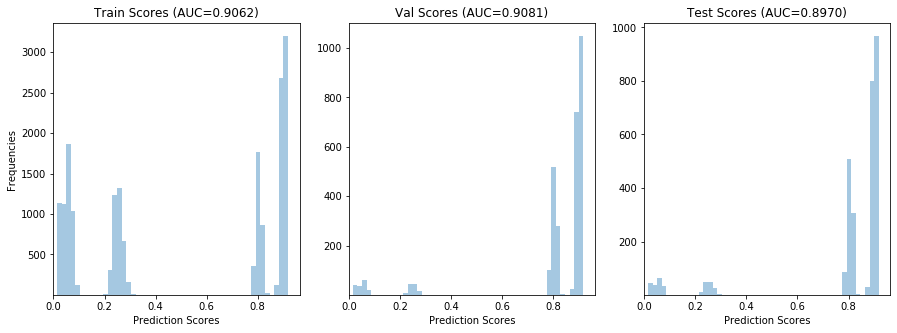

Visualizing SHAP values of VAL examples...


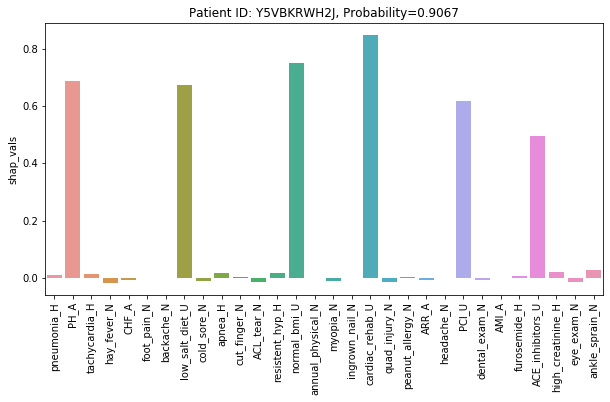

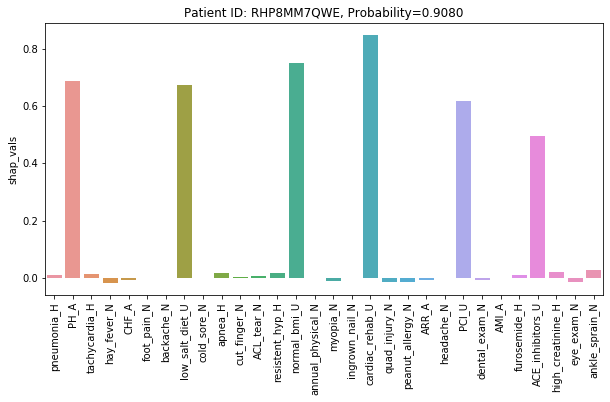

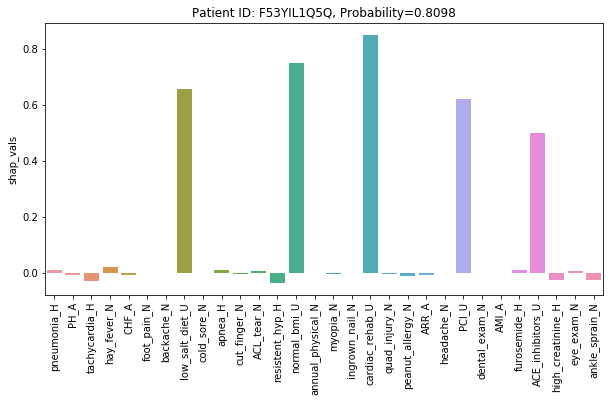

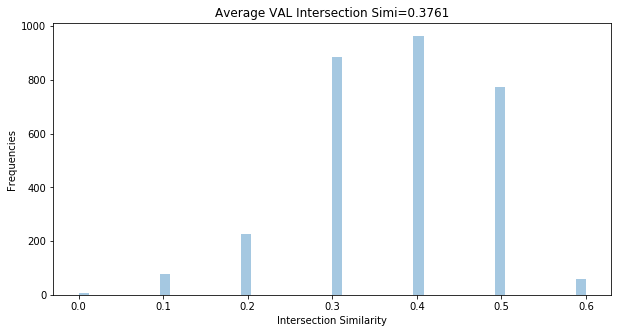

Visualizing SHAP values of TEST examples...


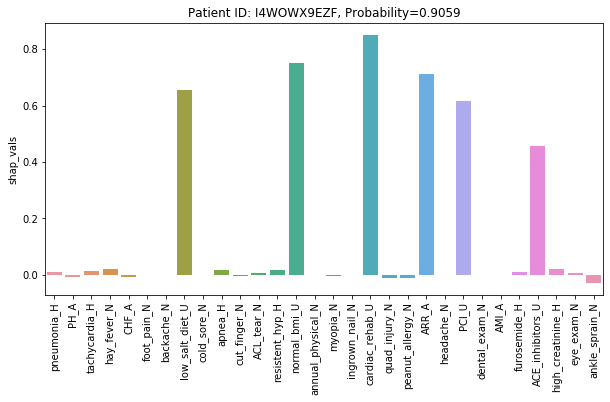

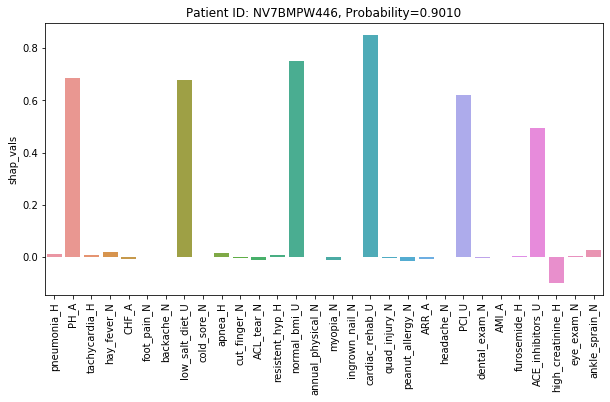

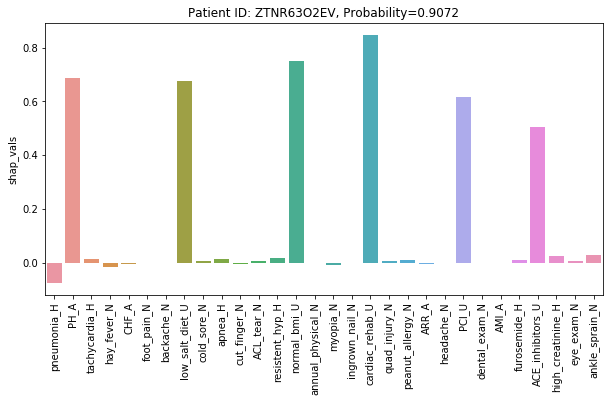

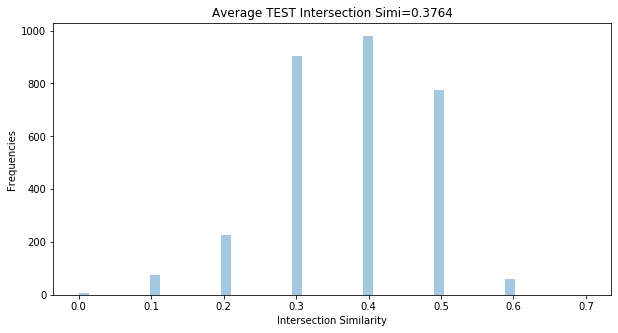

Finally computing and visualizing the global feature importance of the best model....


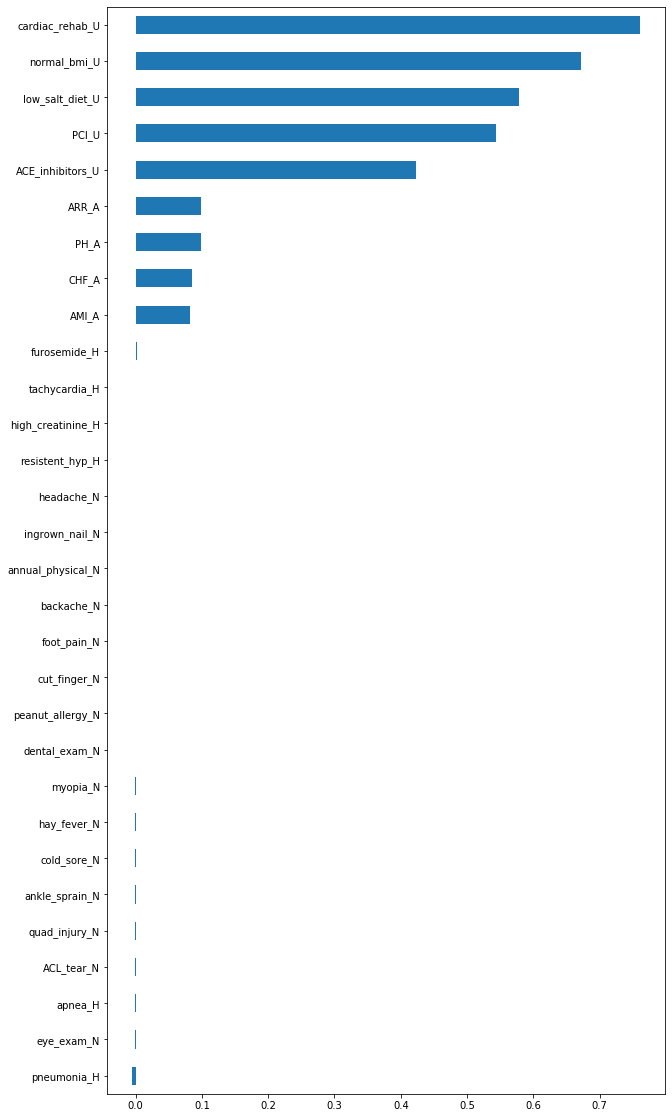

All tasks SUCCESSFULLY completed!


In [23]:
result = compute_shap(
    best_model_info,
    shap_save_path_pattern,
    df_train,
    df_val,
    df_test,
    absolute=SHAP_SCORE_ABSOLUTE,
    test_positive_only=TEST_POSITIVE_ONLY,
    save_output=False,
    visualize=True,
)